# BLAST at local computer
Here we provide a tool for the following works:
* download genome data from NCBI
* check downloaded genome data files by MD5 value
* make a local custom genome database
* update the local custom genome database
* run BLAST search against the local custom genome database
* extract BLAST hit sequences

This Jupyter notebook **Blast_at_local_computer.ipynb** should be run in a linux system, in which the following packages should be installed:
* `parallel`
* `rsync` 
* `ncbi-blast+` 

## Download FTP address

The genome data should be downloaded from the NCBI FTP site according to the FTP address. To get the FTP address, a custom assembly ID table should be provided as shown in the following steps:
1. go to the NCBI Assembly website
2. search the assemblies for the costumed genome database
3. download the ID table 

Here is an example to get assembly ID table for *Listeria monocytogenes*. 

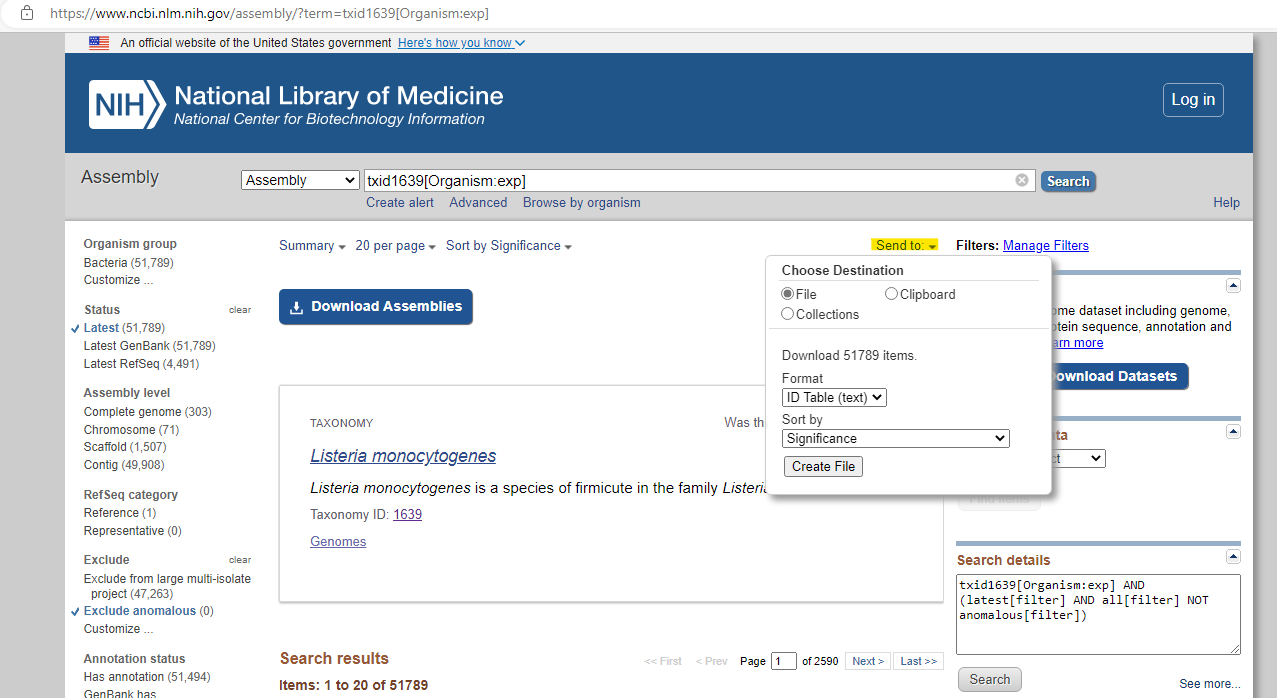
By clicking *Send to -> File -> Format -> ID Table -> Create File, a file assembly_result_table.txt can be downloaded.

You can also download several custom assembly ID tables and merge to one. For example, to build a genome database with both *L. monocytogenes* genome data and *Bacillus subtilis* genome data, the assembly ID tables of these two species should be merged and provided. 

In [ ]:
import blast_at_local_tools as b

In [ ]:
import pandas as pd
import os

In [ ]:
#universal variables

os.chdir("./") #set your working direction

if os.path.exists(os.getcwd() + "/Data/"): #a folder named "Data" should be in the working direction
    pass
else:
    os.mkdir(os.getcwd() + "/Data/")

email = "your.email@example.org" #To make use of NCBI's E-utilities, NCBI requires you to specify your email address with each request.

process_number = 2 #the number of threads for muilti threads work 


In [ ]:
os.getcwd()# check the working direction
os.listdir(".") 

### Read GCA number
An example assembly ID table file is provided in the `Data/` folder.

In [ ]:
table = pd.read_csv("Data/example_assembly_result_table.txt",
                   sep="\t",
                   index_col=0)
table.head()

In [ ]:
GCA_list = table.index
GCA_list

### Download the FTP addresses and the metadata
The FTP addresses will be saved in txt files, and the meta data will be saved in json files. 

Three folders should be made in the `Data` folder in advance to save the downloaded files:
* ftp
* jsons
* download_genome

#### Just download one genome metadata and the genome data
The function `get_assemblies` can also be used to download genome data directly, but it only works properly for small-scale downloading.

In [ ]:
#download genome metadata and genome data for GCA_000196035.1
gca_id = "GCA_000196035.1"
b.get_assemblies(gca_id, download=True, email = email)

#### Download the FTP addresses and the metadata for all the record in the assembly ID table

In [ ]:
b.ftp_download(GCA_list,email = email)

Sometimes, not all the genome FTP addresses and the metadata are successfully downloaded.

In [ ]:
b.ftp_re_download(email = email)

Repeat this code cell untill the genome FTP addresses and the metadata for all the assembly IDs are successfully downloaded.

## Download genome data

The rsync file transfer program is used to download genome data, because it is recommend by NCBI to download large data files, and it is much more efficient and stable than other older protocols.

### Modify FTP address

To use the rsync file transfer program, the downloaded FTP address should be modified first. 

In [ ]:
b.ftp_to_rsync(process_num = process_number)

### Download genome data based by rsync

In [ ]:
b.genome_download() 

Sometimes, not all the genome data are successfully downloaded.

In [ ]:
b.genome_re_download()

Repeat this code cell untill all the genome data are successfully downloaded.

## Check downloaded genome files
The MD5 checksum is used to chech if downloaded genome files are consistent.

### Download MD5 files

In [ ]:
b.ftp_to_md5(process_num=process_number)

In [ ]:
b.md5_download()

Sometimes, not all the MD5 files are successfully downloaded.

In [ ]:
b.md5_re_download()

Repeat this code cell untill all the md5 files are successfully downloaded.

### Generate md5 file based on downloaded genome files
Based on a genome file, hash algorithm can generate an unique md5 value. Therefore, the local genome can be used to generate a md5 value, which can be compared with the downloaded md5 value. The matching md5 values indicate the downloaded genome file is the same as the one on the NCBI website. 

In [ ]:
b.md5_generate(process_num = process_number)

In [ ]:
b.md5_check(process_num = process_number) #set show_not_match=True to check the unmatched file

## BLAST with local genome database

The code to efficently make genome database and run BLAST by using `ncbi-blast+` has been published previously (See [OrthoSLC](https://github.com/JJChenCharly/OrthoSLC) from [JJChenCharly](https://github.com/JJChenCharly)). We also use these code with modifications to make genome database and run BLAST. 

### Make BLAST database

In [ ]:
#unzip downloaded genome data
b.g_unzip()

In [ ]:
b.make_database(process_num = process_number)

### Run BLAST
A query file is needed to run BLAST, which is a fasta file with query sequence(s). 

An example query file is provided in the `Data/` folder. There are two query sequences in the example query file which are *sigB* and *prfA* from *L. monocytogenes* EGDe. 

In [ ]:
b.blast(process_num = process_number)

## BLAST database update

Genome data is growing very fast. Therefore, the BLAST database should be updated once a while. To update the BLAST database, the new custom assembly ID table should be provided. 

An example new assembly ID table file is provided in the `Data/` folder. Compared to the previous assembly ID table, two new assemblies have been added and one old assembly has been removed. 

In [ ]:
#old ID table
table = pd.read_csv("Data/example_assembly_result_table.txt",
                   sep="\t",
                   index_col=0)
table.head()

In [ ]:
#new ID table
table_new = pd.read_csv("Data/example_new_assembly_result_table.txt",
                   sep="\t",
                   index_col=0)
table_new.head()

In [ ]:
GCA_list = table.index
GCA_list_new = table_new.index

In [ ]:
GCA_list_update_plus = set(GCA_list_new).difference(set(GCA_list)) #new data need to be download
GCA_list_update_minus = set(GCA_list).difference(set(GCA_list_new)) #old data need to be removed

print(len(GCA_list_update_plus), "new genome data should be added." )
print(len(GCA_list_update_minus), "old genome data should be removed." )

Same as previous steps, FTP address should be download first.

In [ ]:
b.ftp_download(GCA_list_update_plus, download_path = "Data/update/")

In [ ]:
b.ftp_re_download(download_path = "Data/update/")

Then the genome data can be downloaded by rsync.

In [ ]:
b.ftp_to_rsync(ftp_path = "Data/update/ftp/",
               rsync_path = "Data/update/rsync/",
               process_num = process_number)

In [ ]:
b.genome_download(genome_path = "Data/update/download_genome/",
                  rsync_path = "Data/update/rsync/") 

In [ ]:
b.genome_re_download(genome_path = "Data/update/download_genome/",
                     rsync_path = "Data/update/rsync/")

Then the downloaded genome should be checked by MD5.

In [ ]:
b.ftp_to_md5(ftp_path = "Data/update/ftp/", 
             md5_address_path = "Data/update/md5_address/", 
             process_num=process_number)

In [ ]:
b.md5_download(md5_download_path = "Data/update/download_md5/", 
               md5_address_path = "Data/update/md5_address/")

In [ ]:
b.md5_re_download(md5_download_path = "Data/update/download_md5/", 
                  md5_address_path = "Data/update/md5_address/")

In [ ]:
b.md5_generate(md5_generate_path = "Data/update/generate_md5/", 
               genome_path = "Data/update/download_genome/", 
               process_num = process_number)

In [ ]:
b.md5_check(md5_generate_path = "Data/update/generate_md5/", 
            md5_download_path = "Data/update/download_md5/",
            process_num = process_number) #set show_not_match=True to check the unmatched file

The downloaded genome should be unziped, constructed as database and add to database folder. 

In [ ]:
b.g_unzip(genome_path = "Data/update/download_genome/")

In [ ]:
b.make_database(genome_path = "Data/update/download_genome/",
                blastdb_path = "Data/blast_db/",
                process_num = process_number)

Finally, removed the database which is not included in the assembly ID table anymore.

In [ ]:
b.database_remove_old(GCA_list_remove = GCA_list_update_minus)

## BLAST result analysis
There are several ways to analyze the BLAST result. Here we provide two tools:
* extract the BLAST result sequences and save as a fasta file, which can be used for further alignment analysis
* extract the BLAST result table for each query sequence against every genome database


### Extract sequence

In [ ]:
b.blast_result_seq(process_num = process_number)

### Extract BLAST result table

In [ ]:
b.blast_result_df()